<Center>
<b>Assignment 1: </b><br> 
Cornelis de Jager n8891974 <br>
Daniel Brandenburg n8867887 <br>
Joel Schwaber n10241337 
</center>

In [1]:
# Run this if pydot needs to be installed
!pip install pydot
!pip install eli5
!pip install imblearn

In [2]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats
import eli5

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

# Import ML libraries
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Set a random state value
rs = 10

#import libraries to visualize decision trees
import pydot
from io import StringIO


# Ignore Warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

In [3]:
def categoricalPlot(cat, cat2 = 'IsBadBuy'): # Cat is the carigorical as a string i.e 'Size'
    pd.crosstab(data[cat],data[cat2]).plot(kind="bar")

def IdentifyOutliers (column):
    data_described = column.describe()
    Q1 = data_described["25%"]
    Q3 = data_described["75%"]
    IQR = Q3-Q1
    lowerLimit = Q1 - 1.5 * IQR
    upperLimit = Q3 + 1.5 * IQR
    output = [np.nan] * len( column )
    for i in range(len(column)):
        value = column[i]
        if value < lowerLimit or value > upperLimit:
            output[i] = True
        else:
            output[i] = False
    return output

def analyse_feature_importance(dm_model, feature_names, n_to_display=5):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])
        
# Define a function to find the root node
def getTreeInfo(model, feature_names):
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    features  = [feature_names[i] for i in model.tree_.feature]    

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    leaf_count = 0
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
        
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_count += 1
            is_leaves[node_id] = True


    main_variables = "Root feature is " 
    main_variables += features[0]
    main_variables += "\n"
    main_variables += "Competing featues are "
    main_variables += features[1]
    main_variables += 'and '
    main_variables += features[2]
    return [n_nodes, leaf_count, main_variables]
    
# Write a function that imputes median
def ImputeMean(series):
    return series.fillna(series.mean())

def Normalize (column):
    column =  (column - column.min())/(column.max() - column.min())
    return column

def LogTransform (column):
    column = math.log(column)

In [4]:
def PreProcessing (data):
    print("Pre-Processing Step")
    
    # Check if there are any missing target variables
    if data['IsBadBuy'].isna().any():
        print("Missing Target Variables")
    else:
        print("No missing Target Variables")
    
    
    # Handle Bad Columns drop Columns
    data.drop(['PRIMEUNIT', 'AUCGUART', 'WheelTypeID', 'ForSale', 'PurchaseDate', 'IsOnlineSale'], 
              axis=1, 
              inplace=True)
    

    # Handle Missing Values
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Hyundai':
            data['TopThreeAmericanName'][i] = 'HYUNDAI'
        i += 1
        
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Jeep':
            data['TopThreeAmericanName'][i] = 'JEEP'
        i += 1
        
        
    # Standardise the capitilization across all object rows
    obj_cols = data.select_dtypes(include='object').columns # Create a list of col names
    for i in obj_cols:              # Interate over the obj_cols list
        data[i] = data[i].str.upper()   # Convert all strings to uppercase  
    # Standardize USA to AMERICA
    data['Nationality'].replace({'USA' : 'AMERICAN'}, inplace = True)
    
    # Turn Transmission into a binary variable with Auto = 1 and Manual = 0
    data.rename({'Transmission' : 'Auto'}, axis = 1, inplace = True)
    # Replace binary columns with 1s and 0s
    data['Auto'].replace({'MANUAL' : 0, 'AUTO' : 1}, inplace=True)
    
    # Remove NOT AVAIL in color and place it in the NaN section
    data['Color'].replace({'NOT AVAIL': np.nan}, inplace = True)
    
    
     #This is the significance test for 
    # Check to see if VNST is a statisically significant variable
    # Create a distribution of IsBuyBad for VNST
    VNST_badBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[0]
    VNST_goodBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[1]
    pd.crosstab(data['VNST'],data['IsBadBuy']).plot(kind="bar")
    
    # Use a Chi2 test to test if there is any corrilation between them, if there is
    # (p < 0.05) discarde the variable
    fScore, pValue = stats.f_oneway(VNST_badBuy, VNST_goodBuy)
    print("The pValaue is " + str(pValue) + " which is significant enough to reject null hypothesis")
    print("Drop VNST due to statistical insignificance")
    data.drop('VNST', axis=1, inplace = True)
    
    # Seperate the Size feature into Size and Body
    tempSize = data['Size'].str.split(' ', expand = True) # Create temp var with split column
    data['Size'] = tempSize[0] # Save the temp var back into data
    data['Body'] = tempSize[1] # Save the temp var back into data
    data['Body'].fillna('CITY', inplace = True) # Assume any other cars are 'City'
    
    
    data.loc[data.Size == 'VAN', 'Body'] = 'Van' # Convert Van into a body type
    data.loc[data.Size == 'VAN', 'Body'] =  np.nan # Take van away from size, shouldn't matter once OH is done
    
    # Converting the TimeStamp into Quater
    Quarter = [] # Create empty string
    for i, _ in enumerate(data.PurchaseTimestamp): # Loop over the entire dataset
        # Convert the epoch datetime into the quater and append to list
        Quarter.append(pd.Timestamp(data.PurchaseTimestamp.loc[i], unit = 's').quarter)        
    data['Quarter'] = Quarter # Create the column with list
    data.drop('PurchaseTimestamp', axis=1, inplace = True) # Drop old TimeStamp
    
    """ This will take care of any Null values we don't specifically take care of
    by replaceing the missing data with data from the same distibution"""
   
    data['MMRAcquisitionAuctionAveragePrice'] = data['MMRAcquisitionAuctionAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitionAuctionCleanPrice'] = data['MMRAcquisitionAuctionCleanPrice'].replace(0, np.nan)
    data['MMRAcquisitionRetailAveragePrice'] = data['MMRAcquisitionRetailAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitonRetailCleanPrice'] = data['MMRAcquisitonRetailCleanPrice'].replace(0, np.nan)
    data['MMRCurrentAuctionAveragePrice'] = data['MMRCurrentAuctionAveragePrice'].replace(0, np.nan)
    data['MMRCurrentAuctionCleanPrice'] = data['MMRCurrentAuctionCleanPrice'].replace(0, np.nan)
    data['MMRCurrentRetailAveragePrice'] = data['MMRCurrentRetailAveragePrice'].replace(0, np.nan)
    data['MMRCurrentRetailCleanPrice'] = data['MMRCurrentRetailCleanPrice'].replace(0, np.nan)  
    data['MMRCurrentRetailRatio'] = data['MMRCurrentRetailRatio'].replace(0, np.nan) 
    
    # Impute and normalize
    data["MMRAcquisitionAuctionAveragePrice"] = ImputeMean(data["MMRAcquisitionAuctionAveragePrice"])
    data["MMRAcquisitionAuctionCleanPrice"] =  ImputeMean(data["MMRAcquisitionAuctionCleanPrice"])
    data["MMRAcquisitionRetailAveragePrice"] =  ImputeMean(data["MMRAcquisitionRetailAveragePrice"])
    data["MMRAcquisitonRetailCleanPrice"] =  ImputeMean(data["MMRAcquisitonRetailCleanPrice"])
    data["MMRCurrentAuctionAveragePrice"] =  ImputeMean(data["MMRCurrentAuctionAveragePrice"])
    data["MMRCurrentAuctionCleanPrice"] =  ImputeMean(data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailAveragePrice"] =  ImputeMean(data["MMRCurrentRetailAveragePrice"])
    data["MMRCurrentRetailCleanPrice"] =  ImputeMean(data["MMRCurrentRetailCleanPrice"])
    data['MMRCurrentRetailRatio'] = ImputeMean(data['MMRCurrentRetailRatio'])
    
    data["VehOdo"] = ImputeMean(data["VehOdo"])
    data["VehBCost"] = ImputeMean(data["VehBCost"])
    data["WarrantyCost"] = ImputeMean(data["WarrantyCost"])
      
    print("Drop rows that offer no new information")
    data.drop('MMRAcquisitionAuctionAveragePrice', inplace = True, axis = 1) 
    data.drop('MMRCurrentAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailAveragePrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionRetailAveragePrice', inplace = True, axis = 1)
    
    conv = []
    for i in data.columns: # Loop over dataset
        if data[i].isna().any() == True: # Check to see if there is a NaN is the feature
            dist = data[i].value_counts(normalize=True) # Find the distrabution of the column
            missing = data[i].isna() # Find where the NaN are
            # Replace the NaNs with values from the same distrabution of the column
            data.loc[missing, i] = np.random.choice(dist.index, size=len(data[missing]),p=dist.values)       
            conv.append(i)
            
    print("Converted all of " , conv, "s missing values into the same distrubution")
    
    
    # Do the box plot
    
    fig = plt.figure()
    data.boxplot(column=['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice'], grid = False, rot = 30)
    plt.savefig('preOutlierBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('preOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
     # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.5)
    ax1 =  data["MMRAcquisitionAuctionCleanPrice"].hist()
    ax1.set_title("MMRAcquisitionAuctionCleanPrice")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["MMRAcquisitonRetailCleanPrice"].hist()
    ax2.set_title("MMRAcquisitonRetailCleanPrice")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionCleanPrice"].hist()
    ax3.set_title("MMRCurrentAuctionCleanPrice")
    ax3.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailCleanPrice"].hist()
    ax4.set_title("MMRCurrentRetailCleanPrice")
    ax4.grid(False)    
    
    plt.savefig('preOutlierHist1', bbox_inches = "tight")
    plt.show()

     # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.45)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")
    ax3.grid(False)
    
    
    plt.savefig('preOutlierHist2', bbox_inches = "tight")
    plt.show()
    ## Identify and Remove outiers
    outliers = (IdentifyOutliers(data["MMRAcquisitionAuctionCleanPrice"]) and
                IdentifyOutliers(data["MMRAcquisitonRetailCleanPrice"]) and
                IdentifyOutliers(data["MMRCurrentAuctionCleanPrice"]) and
                IdentifyOutliers(data["MMRCurrentRetailCleanPrice"]) and
                IdentifyOutliers(data["VehOdo"]))
    
    # Select lines that aren't outliers
    num_lines =  len(data["MMRCurrentRetailCleanPrice"])
    data = data[[not i for i in outliers]]
    print ("Lines Removed: ", num_lines - len(data["MMRCurrentRetailCleanPrice"]))
    
    # Do the box plot
    fig = plt.figure()
    data.boxplot(column=['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice'], grid = False, rot = 30)
    plt.savefig('PostOutlierBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('PostOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
    
    # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.5)
    ax1 =  data["MMRAcquisitionAuctionCleanPrice"].hist()
    ax1.set_title("MMRAcquisitionAuctionCleanPrice")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["MMRAcquisitonRetailCleanPrice"].hist()
    ax2.set_title("MMRAcquisitonRetailCleanPrice")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionCleanPrice"].hist()
    ax3.set_title("MMRCurrentAuctionCleanPrice")
    ax3.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailCleanPrice"].hist()
    ax4.set_title("MMRCurrentRetailCleanPrice")
    ax4.grid(False)    
    plt.savefig('postOutlierHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.45)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")
    ax3.grid(False)
    
    
    plt.savefig('preOutlierHist2', bbox_inches = "tight")
    plt.show()
    # Transform the skew values
    data["MMRCurrentAuctionCleanPrice"] = np.sqrt(data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailCleanPrice"] = np.sqrt(data["MMRCurrentRetailCleanPrice"])
    data["MMRAcquisitionAuctionCleanPrice"] = np.sqrt(data["MMRAcquisitionAuctionCleanPrice"])
    data["MMRAcquisitonRetailCleanPrice"] = np.sqrt(data["MMRAcquisitonRetailCleanPrice"])
    data["VehBCost"] = np.sqrt(data["VehBCost"])

    data["WarrantyCost"] = np.log(data["WarrantyCost"])
    
    data["MMRCurrentAuctionCleanPrice"] = Normalize(data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailCleanPrice"] = Normalize(data["MMRCurrentRetailCleanPrice"])
    data["MMRAcquisitionAuctionCleanPrice"] = Normalize(data["MMRAcquisitionAuctionCleanPrice"])
    data["MMRAcquisitonRetailCleanPrice"] = Normalize(data["MMRAcquisitonRetailCleanPrice"])
    
    data["VehOdo"] = Normalize(data["VehOdo"])
    data["VehBCost"] = Normalize(data["VehBCost"])
    data["WarrantyCost"] = Normalize(data["WarrantyCost"])
    
    # Do the box plot
    fig = plt.figure()
    data.boxplot(column=['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice'], grid = False, rot = 30)
    plt.savefig('PostTransformationBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('PostTransformationOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
    # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.5)
    ax1 =  data["MMRAcquisitionAuctionCleanPrice"].hist()
    ax1.set_title("MMRAcquisitionAuctionCleanPrice")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["MMRAcquisitonRetailCleanPrice"].hist()
    ax2.set_title("MMRAcquisitonRetailCleanPrice")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionCleanPrice"].hist()
    ax3.set_title("MMRCurrentAuctionCleanPrice")
    ax3.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailCleanPrice"].hist()
    ax4.set_title("MMRCurrentRetailCleanPrice")
    ax4.grid(False)    
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.45)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")
    ax3.grid(False)
    
    
    plt.savefig('preOutlierHist2', bbox_inches = "tight")
    plt.show()
    
    """ plot the categorial data """
    fig = plt.figure()
    ax1 =  data["Make"].value_counts().plot(kind = 'bar')
    ax1.set_title("Make")
    ax1.grid(False)
    plt.savefig('makeHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 =  data["Color"].value_counts().plot(kind = 'bar')
    ax1.set_title("Color")
    ax1.grid(False)
    plt.savefig('colourHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.8, wspace = 0.4)
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["VehYear"].value_counts().plot(kind = 'bar', rot = 90)
    ax1.set_title("VehYear")
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["Auction"].value_counts().plot(kind = 'bar', rot = 90)
    ax2.set_title("Auction")
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["Size"].value_counts().plot(kind = 'bar', rot = 90)
    ax3.set_title("Size")
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["Body"].value_counts().plot(kind = 'bar', rot = 90)
    ax4.set_title("Body")
    ax4.grid(False)
    plt.savefig('othersHist', bbox_inches = "tight")
    plt.show()
    
   
    """ This should be the last thing done """
    # Convert all categorical variables into one hot representations
    
    print("The number of features before one hot encoding is " + str(data.shape[1]))
    data_OH = pd.get_dummies(data, columns = ['Auction', 'Make', 'Color', 'VehYear', 
                                              'Nationality', 'Size', 'Body', 'TopThreeAmericanName', 
                                              'WheelType', 'Quarter'])
    print("The number of features after one hot encoding is " + str(data_OH.shape[1]))
    data_OH ["IsBadBuy"] = data['IsBadBuy']
    
    data.describe()
    data.info()
    
    return data, data_OH

Pre-Processing Step
No missing Target Variables
The pValaue is 0.0025217411235946108 which is significant enough to reject null hypothesis
Drop VNST due to statistical insignificance
Drop rows that offer no new information
Converted all of  ['Auction', 'VehYear', 'Make', 'Color', 'Auto', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'Body'] s missing values into the same distrubution


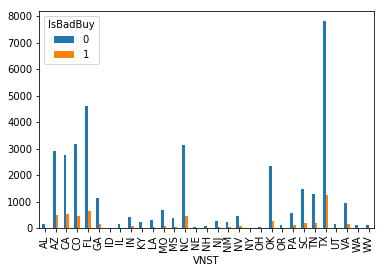

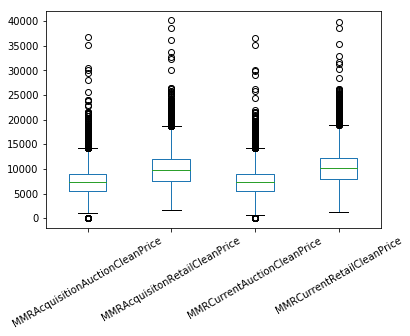

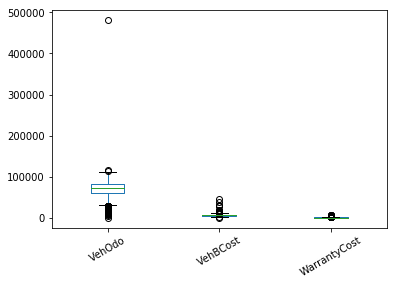

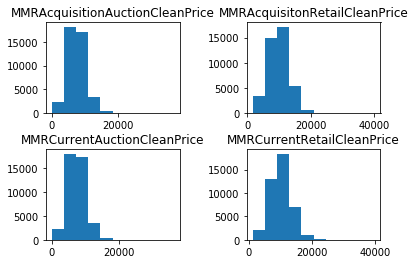

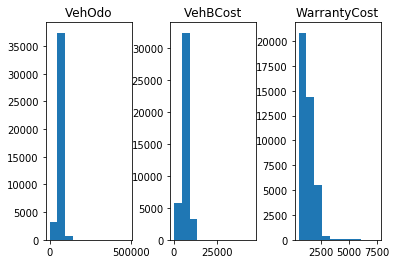

Lines Removed:  187


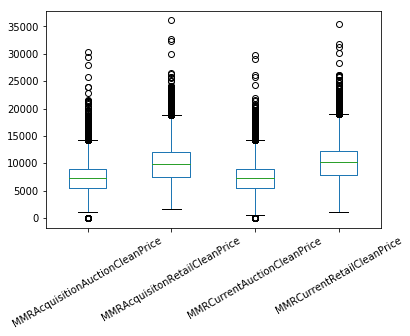

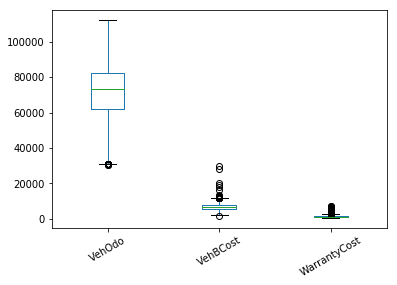

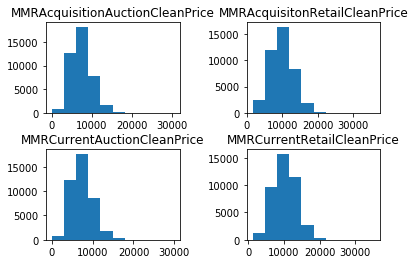

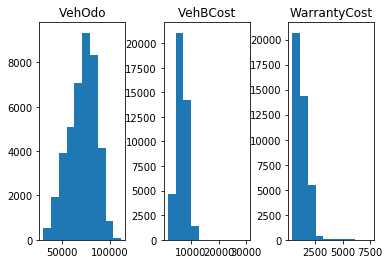

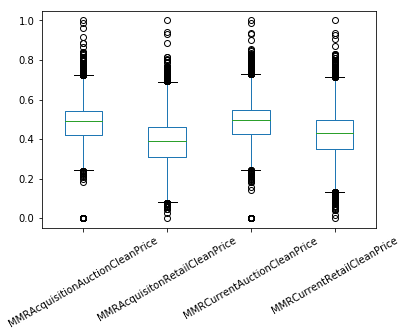

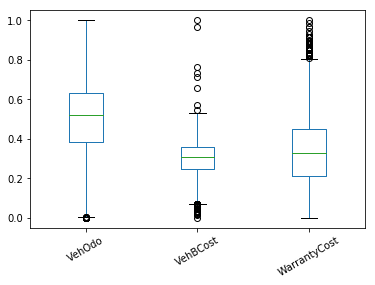

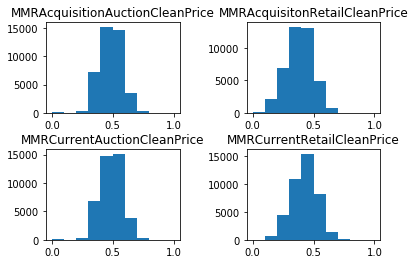

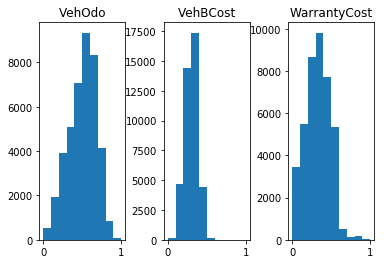

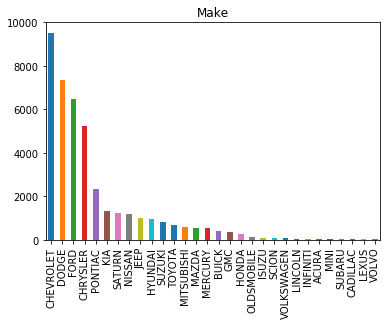

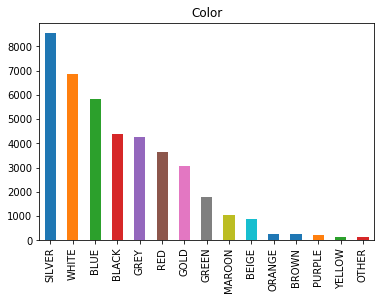

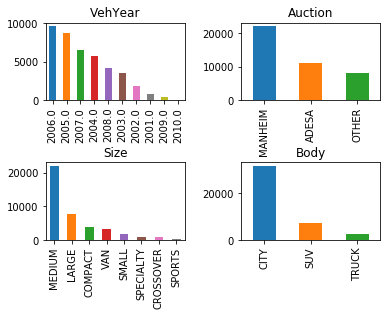

The number of features before one hot encoding is 20
The number of features after one hot encoding is 94
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41289 entries, 0 to 41475
Data columns (total 20 columns):
Auction                            41289 non-null object
VehYear                            41289 non-null float64
Make                               41289 non-null object
Color                              41289 non-null object
Auto                               41289 non-null float64
WheelType                          41289 non-null object
VehOdo                             41289 non-null float64
Nationality                        41289 non-null object
Size                               41289 non-null object
TopThreeAmericanName               41289 non-null object
MMRAcquisitionAuctionCleanPrice    41289 non-null float64
MMRAcquisitonRetailCleanPrice      41289 non-null float64
MMRCurrentAuctionCleanPrice        41289 non-null float64
MMRCurrentRetailCleanPrice         4128

In [5]:
data_raw = pd.read_csv("Kick.csv", # Read the csv into a DF
                   index_col = 'PurchaseID', 
                   na_values = ('?',  '#VALUE!'))

data, data_OH = PreProcessing(data_raw) # PreProcess the data

counts = data["IsBadBuy"].value_counts()
total = data["IsBadBuy"].count()
    
# calculate the percentage
# kick is where IsBadBuy == 1
kickPersentage = counts[1] / total * 100
print ("Questin 1.1 :")
print( kickPersentage, "%")

# target/input split
y = data_OH['IsBadBuy']
X = data_OH.drop(['IsBadBuy'], axis=1)

X_mat = X.values # Canvert X into a matrix
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)

# Do the resampling
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

feature_names = X.columns

<h1>Task 2: Decision Trees</h1>

In [6]:
# simple decision tree training
DecisionTreeModel = DecisionTreeClassifier(random_state=rs)
DecisionTreeModel.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

<h2>Task 2.1</h2>
<h3>A: What is the test accuracy?</h3>    

In [7]:
print("Test Model Accuracy:", DecisionTreeModel.score(X_test, y_test))
print("Train Model Accuracy:", DecisionTreeModel.score(X_train, y_train))

Test Model Accuracy: 0.7922015015742311
Train Model Accuracy: 1.0


In [8]:
# Used through out 2.1
[n_nodes, leaf_count, main_variables] = getTreeInfo(DecisionTreeModel, feature_names) # Call the root function

<h3>B: What is the size of the tree?</h3>  

In [9]:
print("Number of Nodes:", n_nodes)

Number of Nodes: 9521


<h3>C: How many leaves are in the tree that is selected based on the validation data set?</h3>  

In [10]:
print("Number of leaves:", leaf_count)

Number of leaves: 4761


<h3>D: Which variable is used for the first split? What are the competing splits for this first split? </h3> 

In [11]:
print(main_variables)

Root feature is MMRCurrentAuctionCleanPrice
Competing featues are VehBCostand VehOdo


<h3>E: What are the 5 important variables in building the tree?</h3> 

In [12]:
analyse_feature_importance(DecisionTreeModel, feature_names, n_to_display=5)

VehBCost : 0.10993667089352165
MMRCurrentAuctionCleanPrice : 0.10970701715505998
VehOdo : 0.10907308164840507
MMRCurrentRetailRatio : 0.09708541490055374
MMRAcquisitionAuctionCleanPrice : 0.08819894000965199


<h3>F: Report if you see any evidence of model overfitting</h3> 

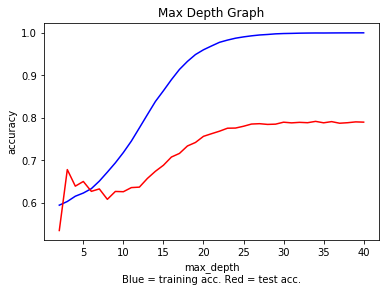

In [13]:
test_score = []
train_score = []

currRange = range(2 , DecisionTreeModel.tree_.max_depth)
# check the model performance for max depth from 2-20
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<p>As seen from the graph above, the training accuracy is 100% where as the test accuracy is nearing 80% - this is an idication of overfitting.</p>

<h3>G: Did changing the default setting help improving the model?</h3> 

In [14]:
splits = math.floor(max_depth/4) # half the number of nodes
model = DecisionTreeClassifier(min_samples_split=10)
model.fit(X_train, y_train)
max_depth = model.tree_.max_depth
splits = math.floor(max_depth/4) # half the number of nodes

<h4>Accuracy</h4>

In [15]:
print("Test Model Accuracy:", model.score(X_test, y_test))
print("Train Model Accuracy:", model.score(X_train, y_train))

# used throughout
[n_nodes, leaf_count, main_variables] = getTreeInfo(model, feature_names) # Call the root function

Test Model Accuracy: 0.7800920319689998
Train Model Accuracy: 0.9894445796960317


<h4> Size of the trees</h4>

In [16]:
# Size of the trees
print("Number of Nodes:", n_nodes)

Number of Nodes: 8767


<h4>Number of leaves</h4>

In [17]:
# Number of leaves
print("Number of leaves:", leaf_count)

Number of leaves: 4384


<h4>Important Splits</h4>

In [18]:
# First Split
print(main_variables)

Root feature is MMRCurrentAuctionCleanPrice
Competing featues are VehBCostand VehOdo


<h4>5 Most important</h4>

In [19]:
# 5 Most important
analyse_feature_importance(model, feature_names, n_to_display=5)

MMRCurrentAuctionCleanPrice : 0.11491649461329558
VehBCost : 0.11330815816477031
VehOdo : 0.10807306154668765
MMRCurrentRetailRatio : 0.09803208348118529
MMRAcquisitionAuctionCleanPrice : 0.08310235867128705


<h4>Sign of overfitting</h4>

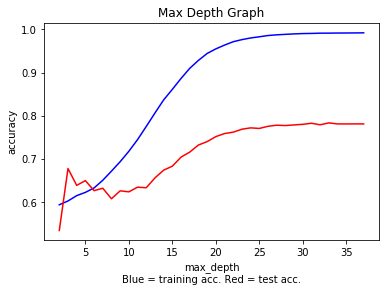

In [20]:
test_score = []
train_score = []

currRange = range(2 , model.tree_.max_depth)
# check the model performance for max depth from 2-20
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs, min_samples_split=splits)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<p>As seen from the graph above, the training accuracy is 100% where as the test accuracy is nearing 80% - this is an idication of overfitting.</p>

<h2>Task 2.2</h2>

In [21]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(2, 7), 'min_samples_leaf': range(20, 60, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
# Save the best features
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_DT = selectmodel.transform(X_train)
X_test_sel_DT = selectmodel.transform(X_test)

<h3>A: What is the classification accuracy on training and test datasets? </h3>   

In [23]:
print("Test Accuracy:", cv.score(X_test, y_test))
print("Train Accuracy:", cv.score(X_train, y_train))

Test Accuracy: 0.6266650520707193
Train Accuracy: 0.6328557020137029


In [24]:
# Used throught out 2.2
[n_nodes, leaf_count, main_variables] = getTreeInfo(cv.best_estimator_, feature_names) # Call the root function

<h3>B: What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?</h3>

In [25]:
print("Number of Nodes:", n_nodes)

Number of Nodes: 117


<p>Yes, due to it being optimised on the best pramaters and we limit the maximum depth.</p>

<h3>C: How many leaves are in the tree that is selected based on the validation data set?</h3>  

In [26]:
print("Number of leaves:", leaf_count)

Number of leaves: 59


<h3>D: Which variable is used for the first split? What are the competing splits for this first split? </h3>  

In [27]:
print(main_variables)

Root feature is MMRCurrentAuctionCleanPrice
Competing featues are VehBCostand VehOdo


<h3>E: What are the 5 important variables in building the tree?</h3>

In [28]:
analyse_feature_importance(cv.best_estimator_, feature_names, n_to_display=5)

MMRCurrentAuctionCleanPrice : 0.31719232175724194
VehBCost : 0.13110845354774436
Body_CITY : 0.09826430760136283
MMRAcquisitionAuctionCleanPrice : 0.08906630036555985
Auction_ADESA : 0.06009860062730013


<h3>F: Report if you see any evidence of model overfitting</h3> 

In [29]:
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv.best_params_)

              precision    recall  f1-score   support

           0       0.91      0.64      0.75      7188
           1       0.19      0.57      0.28      1070

   micro avg       0.63      0.63      0.63      8258
   macro avg       0.55      0.60      0.52      8258
weighted avg       0.82      0.63      0.69      8258

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 30}


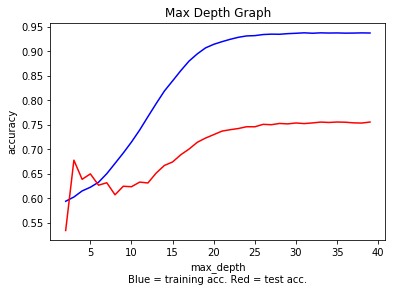

In [30]:
test_score = []
train_score = []

currRange = range(2 , 40)

# check the model performance for max depth from 2-30
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs, min_samples_split=cv.best_params_["min_samples_leaf"])
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<p>As seen in Task 2.2 A - the graph above shows a clear sign of overfitting as the test data is significant'y below the training data.

<h3>G: What are the parameters used? Justify your choices</h3> 

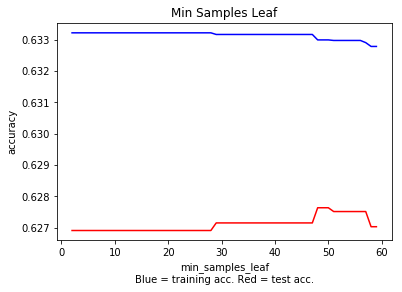

In [31]:
test_score = []
train_score = []

currRange = range(2 , 60)

# check the model performance for max depth from 2-20
for max_leaf in currRange:
    model = DecisionTreeClassifier(max_depth=6, random_state=rs, min_samples_split=max_leaf)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('min_samples_leaf\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Min Samples Leaf')
plt.show()

<p> There are three main choices used for the model: </p>
<p><b>Criterion:</b> gini</p> 
<p><b>max_depth:</b> 25 - we ran the max_depth from the minimum 2 to 40 and found after 6 we are getting deminishing returns, thus 25 was the optimal value (see graph in question F)</p> 
<p><b>min_samples_leaf:</b> 2 - we ran the min_sameples_leaf from the minimum 2 to 60 and found after 47 we are getting deminishing returns, thus 47 was the optimal value (see graph above)</p>

<h2>Task 2.3</h2>
<h4>What is the significant difference do you see between these two decision tree
models (steps 2.1 & 2.2)? How do they compare performance-wise? Explain why
those changes may have happened.</h4>

There are two main differences to concider between the model in 2.1 and 2.2.

<b>Performance</b><br>
Due to the Node size in 2.1 (9000 < nodes), the model performance is much lower than that of 2.2 (120 > nodes). Meaning when running the, 2.2 finds a solution much faster than 2.1

<b>Accuracy</b><br>
Due to the size of the tree in 2.1, one would assume that the accuracy is much higher, however, this is only true for the TRAIN data. Due to the size of the model, overfitting occurs and reduces the accuracy of the model on the TEST data.

The model in 2.2 is much smaller and one would except lower accuracy, but due to the model being well generalized it actually outperforms the overfitted model in 2.1.


<h2>Task 2.4</h2>
<h4>From the better model, can you identify which cars could potential be “kicks”?
Can you provide some descriptive summary of those cars?</h4>

<p>Yes we can predict which cars are kicks and describe the features that are most relevant to the prediction</p>
<b>Accuracy:</b>

In [32]:
De = DecisionTreeClassifier(min_samples_split=2, max_depth = 22)
De.fit(X_train, y_train)

print("Test Model Accuracy:", De.score(X_test, y_test))

Test Model Accuracy: 0.7662872366190361


<p>To get rules out of each attribute we will compare the mean of the kicks and non-kicks to the global mean of all the data. Should a clear pattern no emerge we will do further investigation</p>

<h1 style="color:red;">DONT AVERAGE CLEAN AND AVERAGE MMR PRICE RATHER JUST DROP CLEAN</h1>



<h3>MMRCurrentAuctionPrice (Clean or Average)</h3>

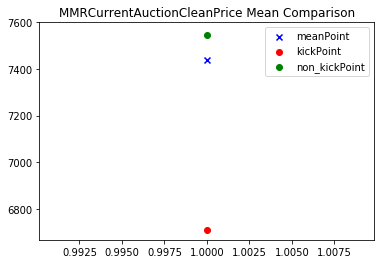

In [33]:
col_name = "MMRCurrentAuctionCleanPrice"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

colors = ['b', 'r', 'g']
fig = plt.figure()
col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

---------------------


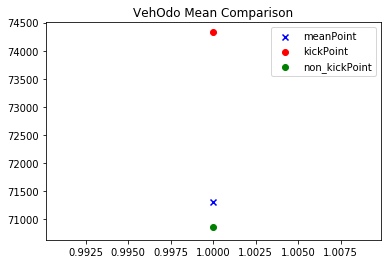

In [34]:

print("---------------------")
col_name = "VehOdo"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

fig = plt.figure()
col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

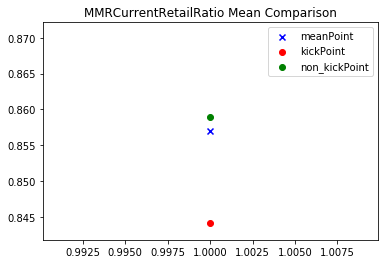

In [35]:

col_name = "MMRCurrentRetailRatio"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

fig = plt.figure()
col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()


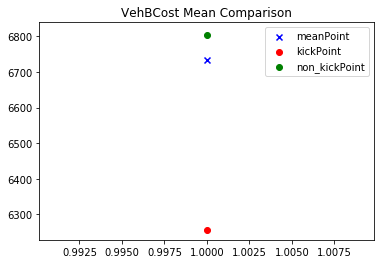

In [36]:


col_name = "VehBCost"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

fig = plt.figure()
col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

In [37]:
col_name = "MMRAcquisitionAuctionCleanPrice"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

fig = plt.figure()
col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

KeyError: 'the label [AcquisitionRetailPrice] is not in the [columns]'

In [ ]:
data_raw.loc[data_raw.IsBadBuy == 1, "MMRCurrentAuctionPrice"].describe()

<h2>Task 3.1</h2>

<p>Yes there were values that needed to be Imputed. These Columns where:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRAcquisitionAuctionAveragePrice <br>
MMRAcquisitionAuctionCleanPrice<br>
MMRAcquisitionRetailAveragePrice<br>
MMRAcquisitonRetailCleanPrice<br>
MMRCurrentAuctionAveragePrice<br>
MMRCurrentAuctionCleanPrice<br>
MMRCurrentRetailAveragePrice<br>
MMRCurrentRetailCleanPrice<br>
MMRCurrentRetailRatio<br>
<br>
VehOdo<br>
VehBCost<br>
WarrantyCost<br>
Color<br>
Auction<br>
VehYear<br>
Make<br>
Auto<br>
WheelType<br>
Nationality<br>
Size<br>
TopThreeAmericanName<br>
</div>


<h2>Task 3.2</h2>
<p>
There were four main transformations done.<br><br>

<b>Removing Outliers</b><br>
<p>After creating histograms and box plots it was noted that there is severe skew. The first step taken to remove the skew was to remove outliers for all varaibles. These columns were:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRAcquisitionAuctionCleanPrice<br>
MMRAcquisitonRetailCleanPrice<br>
MMRCurrentAuctionCleanPrice<br>
MMRCurrentRetailCleanPrice<br>
VehOdo<br>
</div>

<b>Sqaure Root Transformations</b><br>
After the initial removal of outliers, more box plots and histograms were created. From this it was noted that the "Auction" variables still had some skew. To fix this these were transformed using the Sqaur Root of the varaible on the Price variables.
<p>Yes there were values that needed to be Imputed. These Columns where:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRCurrentAuctionCleanPrice<br>
MMRCurrentRetailCleanPrice<br>
MMRAcquisitionAuctionCleanPrice<br>
MMRAcquisitonRetailCleanPrice<br>
VehOdo<br>
</div>

<b>Log Transformations</b><br>
<p>some of the varaibles were found to be better suited to a Log transformation. These variables were:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
VehOdo<br>
WarrantyCost<br>
</div>

<b>Normilising Values</b><br>
All the numerical variables were then normalized for consistency.






<h2>Task 3.3</h2>


In [38]:
# initialise a standard scaler object
model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)
model2 = cv.best_estimator_

<h3>H: Name the regression function used</h3>

<p>LogisticRegression, from the sklearn library</p>

<h3>I: How much was the difference in performance of two models build, default
and optimal?</h3>

<p><b>Standard Model</b></p>

In [39]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.91      0.63      0.75      7188
           1       0.20      0.60      0.29      1070

   micro avg       0.63      0.63      0.63      8258
   macro avg       0.55      0.62      0.52      8258
weighted avg       0.82      0.63      0.69      8258

Train accuracy: 0.6292560776266825
Test accuracy: 0.6289658512957133


<p><b>Optimised Model</b></p>

In [40]:
y_pred = model2.predict(X_test)
print(classification_report(y_test, y_pred))
print("Train accuracy:", model2.score(X_train, y_train))
print("Test accuracy:", model2.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.92      0.64      0.75      7188
           1       0.20      0.60      0.30      1070

   micro avg       0.63      0.63      0.63      8258
   macro avg       0.56      0.62      0.53      8258
weighted avg       0.82      0.63      0.69      8258

Train accuracy: 0.6301603310958857
Test accuracy: 0.6333252603535965


<p> Both the test and train accuracy for both models were very similar at roughly 63%</p>

<h3>J: Show the set parameters for the best model. What are the parameters used?
Explain your decision. What are the optimal parameters?</h3>

In [41]:
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

              precision    recall  f1-score   support

           0       0.92      0.64      0.75      7188
           1       0.20      0.60      0.30      1070

   micro avg       0.63      0.63      0.63      8258
   macro avg       0.56      0.62      0.53      8258
weighted avg       0.82      0.63      0.69      8258

{'C': 1000}


We changed the C value to try and intoduce a l2 regularizing factor to regreduce overfitting. We did not change the solver because the default solver (liblinear) is a great solver for small data sets and supports l2 regularizing. 

<h3>K: Report which variables are included in the regression model.</h3>

We included all that weren't dropped initially. 

<h3>L: Report the top-5 important variables (in the order) in the model.</h3>

In [42]:
# grab feature importances from the model and feature name from the original X
coef = model2.coef_[0]

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 5 features, you can leave this out to print out everything
num_features = 5
indices = indices[:num_features]

for i in indices:
    print(feature_names[i], ':', coef[i])

MMRAcquisitonRetailCleanPrice : 7.10770287434734
Make_VOLVO : -5.75790348453633
Make_HONDA : -5.756791828567824
Make_TOYOTA : -5.570719482933673
MMRAcquisitionAuctionCleanPrice : -5.381313979569812


<h3>M: What is classification accuracy on training and test datasets?</h3>

In [43]:
print("Accuracy for the best performing model on test and train")
print("Train accuracy:", model2.score(X_train, y_train))
print("Test accuracy:", model2.score(X_test, y_test))

Accuracy for the best performing model on test and train
Train accuracy: 0.6301603310958857
Test accuracy: 0.6333252603535965


<h3>N: Report any sign of overfitting</h3>

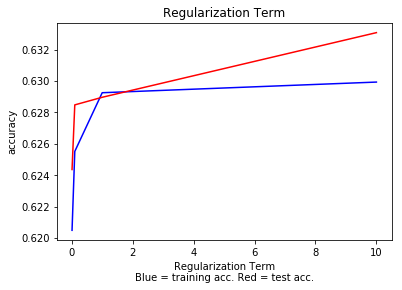

In [44]:
test_score = []
train_score = []

range_ = [pow(10, x) for x in range(-2, 2)]

for i in range_:
    model = LogisticRegression(random_state=rs, C=i)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Regularization Term\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Regularization Term')
plt.show()

We do not have overfitting, this model is under fitting

<h2>Task 3.4</h2>

In [45]:
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

<h3>A: Report which variables are included in the regression model</h3>

In [46]:
# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

print("The columns selected by rfe is/are ")
for i in range(1, len(list(X.columns[rfe.get_support(indices=True)]))):
    print(list(X.columns[rfe.get_support(indices=True)])[i])

Original feature set 93
Number of features after elimination 69
The columns selected by rfe is/are 
VehOdo
MMRAcquisitionAuctionCleanPrice
MMRAcquisitonRetailCleanPrice
MMRCurrentAuctionCleanPrice
MMRCurrentRetailCleanPrice
MMRCurrentRetailRatio
VehBCost
Auction_ADESA
Auction_OTHER
Make_ACURA
Make_BUICK
Make_CADILLAC
Make_CHEVROLET
Make_DODGE
Make_FORD
Make_GMC
Make_HONDA
Make_HYUNDAI
Make_INFINITI
Make_ISUZU
Make_KIA
Make_LEXUS
Make_LINCOLN
Make_MAZDA
Make_MERCURY
Make_MINI
Make_MITSUBISHI
Make_OLDSMOBILE
Make_PONTIAC
Make_SATURN
Make_SCION
Make_SUZUKI
Make_TOYOTA
Make_VOLKSWAGEN
Make_VOLVO
Color_BEIGE
Color_BROWN
Color_GREEN
Color_OTHER
Color_PURPLE
VehYear_2001.0
VehYear_2002.0
VehYear_2003.0
VehYear_2004.0
VehYear_2005.0
VehYear_2006.0
VehYear_2007.0
VehYear_2008.0
VehYear_2009.0
VehYear_2010.0
Nationality_AMERICAN
Nationality_OTHER
Nationality_OTHER ASIAN
Nationality_TOP LINE ASIAN
Size_COMPACT
Size_LARGE
Size_SMALL
Size_SPECIALTY
Size_SPORTS
Size_VAN
Body_SUV
Body_TRUCK
TopThreeA

<h3>B: Report the top-5 important variables (in the order) in the model.</h3>

In [47]:
# Make another model to extract valueable info
# Get best params
params = {'C': [pow(10, x) for x in range(-4, 1)]}
cvRFE = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cvRFE.fit(X_train_sel, y_train)
print(cvRFE.best_params_)

# Get coefs
coefLG = cvRFE.best_estimator_.coef_[0]
# limit to 5 features, you can comment the following line to print out everything
coefLG = coefLG[:5]

for i in range(len(coefLG)):
    print(feature_names[i], ':', coefLG[i])

{'C': 1}
Auto : 0.46220039883911557
VehOdo : 0.5018351164588306
MMRAcquisitionAuctionCleanPrice : -3.4571612458422027
MMRAcquisitonRetailCleanPrice : 5.797161069975764
MMRCurrentAuctionCleanPrice : 2.866804014067079


<h3>C: What are the parameters are used and which are optimal?</h3>

RFECV only used one parameter, which was the logistic regression estimator. We then passed the best features to a gridsearch, finding a C value of 1 was best

<h3>D: Report any signs of overfitting.</h3>

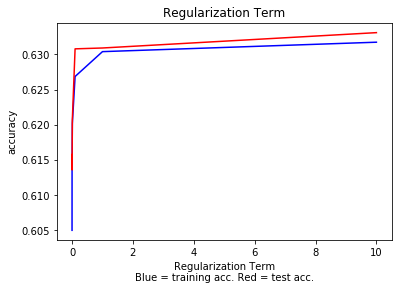

In [48]:
test_score = []
train_score = []

range_ = [pow(10, x) for x in range(-4, 2)]

for i in range_:
    model = LogisticRegression(random_state=rs, C=i)
    model.fit(X_train_sel, y_train)
    
    test_score.append(model.score(X_test_sel, y_test))
    train_score.append(model.score(X_train_sel, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Regularization Term\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Regularization Term')
plt.show()

The model is neither over or under fitting

<h3>E: What is classification accuracy on training and test datasets?</h3>

In [49]:
model = LogisticRegression(random_state=rs, C=1)
model.fit(X_train_sel, y_train)

print("Accuracy for the best performing model on test and train")
print("Train accuracy:", model.score(X_train_sel, y_train))
print("Test accuracy:", model.score(X_test_sel, y_test))

Accuracy for the best performing model on test and train
Train accuracy: 0.6303863944631865
Test accuracy: 0.6309033664325503


<h3>F: Did it improve/worsen the performance?</h3>

The perfomance did not noticable change, with the improved accuracy still around the same as the previous at 63%.

<h2>Task 3.5</h2>

<h2>Task 4.1</h2>

In [50]:
model = MLPClassifier(random_state=rs) # Define the model
model.fit(X_train, y_train) # Fit it
y_pred = model.predict(X_test)

<h3>A: What is the network architecture?</h3>

In [51]:
print("The neural network has ", model.n_layers_, " layers")
print("and ", model.hidden_layer_sizes[0], " nodes per layer")

The neural network has  3  layers
and  100  nodes per layer


<h3>B: How many iterations are needed to train this network?</h3>

In [52]:
print("The model has ran through ", model.n_iter_, " iterations")

The model has ran through  200  iterations


<h3>C: Do you see any sign of over-fitting?</h3>

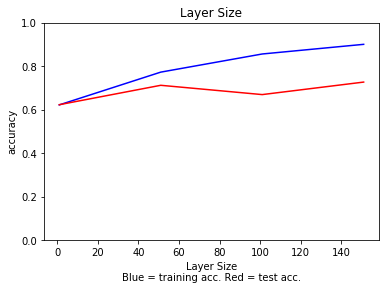

In [75]:
test_score = []
train_score = []

range_ = range(1, 100, 20)

for i in range_:
    model = MLPClassifier(hidden_layer_sizes = i, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Layer Size\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Layer Size')
plt.show()

There is a small amount of overfitting, the training accuracy is just above the test accuracy. 

<h3>D: Did the training process converge and resulted in the best model?</h3>

No, as seen in graph above, the model starts to converge, but then diverges. 

<h3>E: What is classification accuracy on training and test datasets?</h3>

In [54]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Train accuracy: 0.8422251591138316
Test accuracy: 0.7432792443690966
              precision    recall  f1-score   support

           0       0.89      0.72      0.80      7188
           1       0.18      0.40      0.25      1070

   micro avg       0.68      0.68      0.68      8258
   macro avg       0.53      0.56      0.52      8258
weighted avg       0.80      0.68      0.73      8258



<h2>Task 4.2</h2>

In [55]:
# Use GCV and change the no. of hidden nodes
params = {'hidden_layer_sizes': [(x,) for x in range(2, 7)], 'alpha': [pow(10, x) for x in range(-6, 2)]}
cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

<h3>A: What is the network architecture?</h3>

In [56]:
print("The neural network has ", cv.best_estimator_.n_layers_, " layers")
print("and ", cv.best_estimator_.hidden_layer_sizes[0], " nodes per layer")
print("and ", cv.best_estimator_.alpha, " alpha")

The neural network has  3  layers
and  6  nodes per layer
and  0.001  alpha


<h3>B: How many iterations are needed to train this network?</h3>

In [57]:
print("The model has ran through ", cv.best_estimator_.n_iter_, " iterations")

The model has ran through  147  iterations


<h3>C: Do you see any sign of over-fitting?</h3>

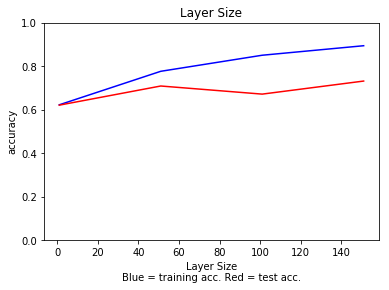

In [76]:
test_score = []
train_score = []

range_ = range(1, 200, 50)

for i in range_:
    model = MLPClassifier(hidden_layer_sizes=i, alpha=0.01, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Layer Size\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Layer Size')
plt.show()

The model is overfitting. The training accuracy is slightly higher than the testing.

<h3>D: Did the training process converge and resulted in the best model?</h3><br>
This model diverges, as seen in the figure above

<h3>E: What is classification accuracy on training and test datasets?</h3>

In [59]:
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Train accuracy: 0.6616700865996592
Test accuracy: 0.614555582465488
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      7188
           1       0.19      0.62      0.29      1070

   micro avg       0.61      0.61      0.61      8258
   macro avg       0.55      0.62      0.51      8258
weighted avg       0.82      0.61      0.68      8258



<h2>Task 4.3</h2>

<b>Decision Tree Features</b>

In [60]:
modelDT = MLPClassifier(hidden_layer_sizes = (6,), alpha = 0.01, random_state=rs) # Define the model
modelDT.fit(X_train_sel_DT, y_train) # Fit it
y_predDT = modelDT.predict(X_test_sel_DT)

<b>RFECV Features</b>

In [61]:
# MLP with rfe features
modelRFE = MLPClassifier(hidden_layer_sizes = (6,), alpha = 0.01, random_state=rs) # Define the model
modelRFE.fit(X_train_sel, y_train) # Fit it
y_predRFE = modelRFE.predict(X_test_sel)

<h3>A: What is the network architecture?</h3>

<b>Decision Tree Features</b>

In [62]:
print("The neural network has ", modelDT.n_layers_, " layers")
print("and ", modelDT.hidden_layer_sizes[0], " nodes per layer")

The neural network has  3  layers
and  6  nodes per layer


<b>RFECV Features</b>

In [63]:
print("The neural network has ", modelRFE.n_layers_, " layers")
print("and ", modelRFE.hidden_layer_sizes[0], " nodes per layer")

The neural network has  3  layers
and  6  nodes per layer


<h3>B: How many iterations are needed to train this network?</h3>

<b>Decision Tree Features</b>

In [64]:
print("The model has ran through ", modelDT.n_iter_, " iterations")

The model has ran through  94  iterations


<b>RFECV Features</b>

In [65]:
print("The model has ran through ", modelRFE.n_iter_, " iterations")

The model has ran through  113  iterations


<h3>C: Do you see any sign of over-fitting?</h3>

<b>Decision Tree Features</b>

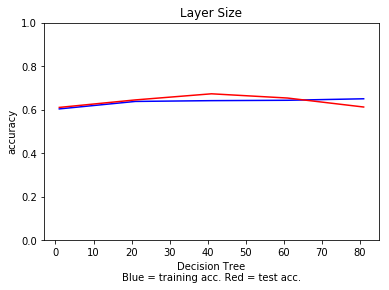

In [77]:
test_score = []
train_score = []

range_ = range(1, 100, 20)

for i in range_:
    model = MLPClassifier(hidden_layer_sizes=i, alpha=0.01, random_state=rs)
    model.fit(X_train_sel_DT, y_train)
    
    test_score.append(model.score(X_test_sel_DT, y_test))
    train_score.append(model.score(X_train_sel_DT, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Decision Tree\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Layer Size')
plt.show()

This model is neither over fitting or underfitting. The training and test accuracy are running very close to each other

<b>RFECV Features</b>

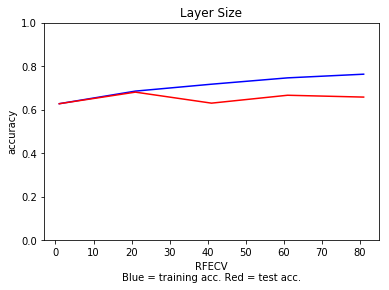

In [78]:
test_score = []
train_score = []

range_ = range(1, 100, 20)

for i in range_:
    model = MLPClassifier(hidden_layer_sizes=i, alpha=0.01, random_state=rs)
    model.fit(X_train_sel, y_train)
    
    test_score.append(model.score(X_test_sel, y_test))
    train_score.append(model.score(X_train_sel, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('RFECV\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Layer Size')
plt.show()

<h3>D: Did the training process converge and resulted in the best model?</h3>

<b>Decision Tree Features</b><br>
This model does seem to converge. The training and test data are very similar.

<b>RFECV Features</b><br>
This model seems to diverge

<h3>E: What is classification accuracy on training and test datasets?</h3>

<b>Decision Tree Features</b>

In [70]:
print("Using features selected from the decision tree, the train accuracy:", modelDT.score(X_train_sel_DT, y_train))
print("Using features selected from the decision tree, the test accuracy:", modelDT.score(X_test_sel_DT, y_test))
print(classification_report(y_test, y_predDT))

Using features selected from the decision tree, the train accuracy: 0.6245261364031579
Using features selected from the decision tree, the test accuracy: 0.5804068781787358
              precision    recall  f1-score   support

           0       0.92      0.57      0.70      7188
           1       0.19      0.67      0.29      1070

   micro avg       0.58      0.58      0.58      8258
   macro avg       0.55      0.62      0.50      8258
weighted avg       0.83      0.58      0.65      8258



<b>RFECV Features</b>

In [71]:
print("Using features selected from the RFECV, the train accuracy:", modelRFE.score(X_train_sel, y_train))
print("Using features selected from the RFECV, the test accuracy:", modelRFE.score(X_test_sel, y_test))
print(classification_report(y_test, y_predRFE))

Using features selected from the RFECV, the train accuracy: 0.6487149167043439
Using features selected from the RFECV, the test accuracy: 0.62460644223783
              precision    recall  f1-score   support

           0       0.91      0.63      0.74      7188
           1       0.19      0.59      0.29      1070

   micro avg       0.62      0.62      0.62      8258
   macro avg       0.55      0.61      0.52      8258
weighted avg       0.82      0.62      0.69      8258



<h2>Task 4.4</h2>

<b>All Data</b>

ROC index on test for DT: 0.5516436402311224
ROC index on test for logistic regression: 0.6674697964936369
ROC index on test for NN: 0.6596614814930387


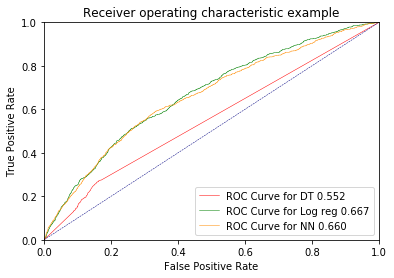

In [82]:
# Decision Tree
modelDT = DecisionTreeClassifier(max_depth = 22, min_samples_split = 2, random_state=rs) # Define the model
modelDT.fit(X_train, y_train) # Fit with data

# Neural network
modelMLP = MLPClassifier(hidden_layer_sizes = 6, alpha = 0.01, random_state=rs) # Define the model
modelMLP.fit(X_train, y_train) # Fit it

# Logisitc Regression
modelLG = LogisticRegression(C = 1, random_state=rs) # Define the model
modelLG.fit(X_train, y_train) # fit it to training data

# Compare the models

# ROC AUC
y_pred_proba_dt = modelDT.predict_proba(X_test)
y_pred_proba_log_reg = modelLG.predict_proba(X_test)
y_pred_proba_nn = modelMLP.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc All Data')
plt.legend(loc="lower right")
plt.show()

<b>Selected Data</b>

ROC index on test for DT: 0.5462257968888958
ROC index on test for logistic regression: 0.6679996255441313
ROC index on test for NN: 0.6544601854596706


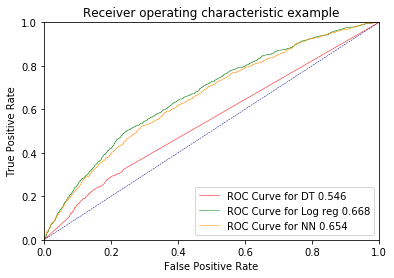

In [83]:
# Decision Tree
modelDT = DecisionTreeClassifier(max_depth = 22, min_samples_split = 2, random_state=rs) # Define the model
modelDT.fit(X_train_sel, y_train) # Fit with data

# Neural network
modelMLP = MLPClassifier(hidden_layer_sizes = 6, alpha = 0.01, random_state=rs) # Define the model
modelMLP.fit(X_train_sel, y_train) # Fit it

# Logisitc Regression
modelLG = LogisticRegression(C = 1, random_state=rs) # Define the model
modelLG.fit(X_train_sel, y_train) # fit it to training data

# Compare the models

# ROC AUC
y_pred_proba_dt = modelDT.predict_proba(X_test_sel)
y_pred_proba_log_reg = modelLG.predict_proba(X_test_sel)
y_pred_proba_nn = modelMLP.predict_proba(X_test_sel)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Selected Data')
plt.legend(loc="lower right")
plt.show()

<b>Which Model Is Better</b><br>
The two ROC graphs above show which model performes better on each data set. The logestic regression model is better both times, with nueral network only slightly worse<br>
<b>Which cars are kicks?</b><br>

<b>Comprehention</b><br>
Which nueral network is better is easy to understand, with graphs showing if a model is overfitting or underfitting, and single number scores a model can be evaluated very quickly. ROC scores and graphs make comparing models beteween each other easy. 

<h2>Task 5.1</h2>

In [90]:
# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=[('dt', modelDT), ('lr', modelLG), ('nn', modelMLP)], voting='soft')

# fit the voting classifier to training data
voting.fit(X_train_sel, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train_sel, y_train))
print("Ensemble test accuracy:", voting.score(X_test_sel, y_test))

Ensemble train accuracy: 0.9261816158313915
Ensemble test accuracy: 0.7526035359651247


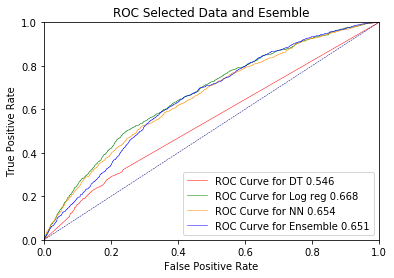

In [93]:
y_pred_proba_vote = voting.predict_proba(X_test_sel)
roc_index_vote = roc_auc_score(y_test, y_pred_proba_vote[:, 1])
fpr_vote, tpr_vote, thresholds_vote = roc_curve(y_test, y_pred_proba_vote[:,1])

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)
plt.plot(fpr_vote, tpr_vote, label='ROC Curve for Ensemble {:.3f}'.format(roc_index_vote), color='blue', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
# lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Selected Data and Esemble')
plt.legend(loc="lower right")
plt.show()

<h3>A: Which model is best?</h3>
The ensemble model is better, and this is because it uses the best model and builds upon it.

<h2>Task 5.2</h2>

<h3> A: Discuss the findings </h3>
<b>ROC</b><br>

<b>Accuracy</b>

<b>Fit</b>

<b>Output</b>


<h3> B: Do all the models agree on charatics of kicks? </h3><br>

<h2>Task 6.1</h2>
<h3>Based on all the models, which one will you use in decision making</h3>

<h2>Task 6.2</h2>
<h3>What are the positives and negatives of each model</h3>
<b>Decision Tree</b>

<b>Logistic Regression</b>

<b>MLP</b>

<b>Esemble</b>

<h2>Task 6.3</h2>
<h3>How can this information be used by decision makers</h3>